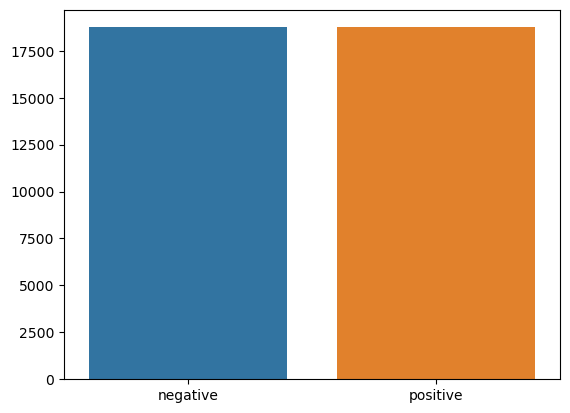

In [1]:
#%%
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#%%
df = pd.read_csv('/Users/toto/fun/experiments/nlp/rnn/data/imdb.csv')

# Splitting to train and test data
x, y = df['review'].values, df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

#%%

# Analysis sentiment

dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative', 'positive']), y=dd);

#%%

# Tokenization

def preprocess_string(s):
  # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"[^\w\s]", '', s)
  # Replace all runs of whitespaces with no space
  s = re.sub(r"\s+", '', s)
  # replace digits with no space
  s = re.sub(r"\d", '', s)
  return s

def finalize(data, vocab):
  final_list = [[vocab[preprocess_string(word)]
    for word in sen.lower().split()
    if preprocess_string(word) in vocab.keys()] for sen in data]

  return final_list

def tokenize(x_train, y_train, x_test, y_test):
  sw = set(stopwords.words('english'))
  word_list = [word for sen in x_train for word in sen.lower().split() if word not in sw and word != '']

  corpus = Counter(word_list)
  # sort by most common words; pick 1000 most common
  corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:1000]

  vocab = {w:i+1 for i, w in enumerate(corpus_)}

  final_list_train = finalize(x_train, vocab)
  final_list_test = finalize(x_test, vocab)

  encoded_train = np.array([1 if y == 'positive' else 0 for y in y_train])
  encoded_test = np.array([1 if y == 'positive' else 0 for y in y_test])
  return final_list_train, encoded_train, final_list_test, encoded_test, vocab

#%%
# padding each of the sequences to max length
def padding(sen, seq_len):
  features = np.zeros((len(sen), seq_len), dtype=int)
  for i, review in enumerate(sen):
    if len(review) != 0:
      features[i, -len(review):] = np.array(review)[:seq_len]
  return features

#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
def create_loader(x_train, y_train, x_test, y_test, batch_size=50):
  x_train, y_train, x_test, y_test, vocab = tokenize(x_train, y_train, x_test, y_test)
  x_train_pad = padding(x_train, 500)
  x_test_pad = padding(x_test, 500)

  # Batching and loading as tensor
  train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
  test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
  return train_loader, test_loader, vocab

#%%

class RNN(nn.Module):
  def __init__(
      self, n_layers,
      vocab_size, hidden_dim,
      embed_dim, out_dim,
      device, drop_prob=0.5):
    super().__init__()

    self.out_dim = out_dim
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    self.embedding = nn.Embedding(vocab_size, embed_dim)

    self.lstm = nn.LSTM(
      input_size=embed_dim,
      hidden_size=self.hidden_dim,
      num_layers=n_layers,
      batch_first=True
    )

    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(self.hidden_dim, out_dim)
    self.sig = nn.Sigmoid()

  def forward(self, x, hidden):
    batch_size = x.size(0)
    embeds = self.embedding(x)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    out = self.dropout(lstm_out)
    out = self.fc(out)

    sig_out = self.sig(out).view(batch_size, -1)
    sig_out = sig_out[:,-1] # get last batch of labels, since it contain all the info

    return sig_out, hidden

  def init_hidden(self, batch_size):
    h0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
    c0 = torch.zeros((self.n_layers, batch_size, self.hidden_dim)).to(device)
    hidden = (h0, c0)
    return hidden

  def predict_text(self, text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())

  def predict(self, index, df):
    index = 1
    print(df['review'][index])
    print('='*70)
    print(f'Actual sentiment is  : {df["sentiment"][index]}')
    print('='*70)
    pro = self.predict_text(df['review'][index])
    status = "positive" if pro > 0.5 else "negative"
    pro = (1 - pro) if status == "negative" else pro
    print(f'Predicted sentiment is {status} with a probability of {pro}')

#%%
train_loader, test_loader, vocab  = create_loader(x_train, y_train, x_test, y_test, batch_size=500)

In [2]:
#%%
n_layers = 2
vocab_size = len(vocab) + 1 # extra one for padding
embed_dim = 64
out_dim = 1
hidden_dim = 256

model = RNN(n_layers, vocab_size, hidden_dim, embed_dim, out_dim, device, drop_prob=0.5)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def acc(pred, y):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == y.squeeze()).item()

clip, epochs = 5, 5
valid_loss_min = np.Inf

epoch_tr_loss, epoch_ts_loss = [], []

model.to(device)
for epoch in tqdm(range(epochs)):
  train_losses = []
  model.train()

  h = model.init_hidden(500)
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    h = tuple([i.data for i in h])

    out, h = model(x, h)
    loss = loss_fn(out, y.float())
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    # help prevent exploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
  model.eval()
  with torch.inference_mode():
    test_losses = []
    h = model.init_hidden(500)
    for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      h = tuple([i.data for i in h])
      
      out, h = model(x, h)
      loss = loss_fn(out, y.float())
      test_losses.append(loss.item())
    
  epoch_tr_loss.append(np.mean(train_losses))
  epoch_ts_loss.append(np.mean(test_losses))

100%|██████████| 5/5 [01:55<00:00, 23.12s/it]


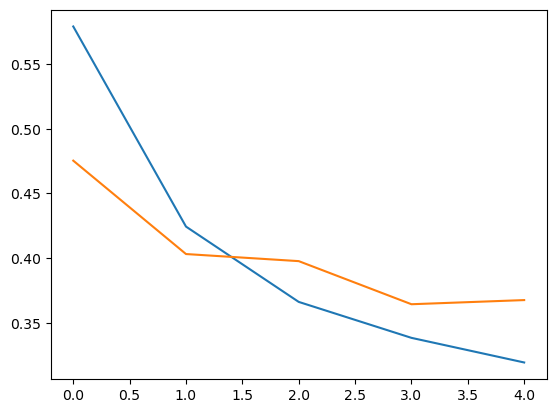

In [3]:
plt.plot(np.arange(len(epoch_tr_loss)), epoch_tr_loss);
plt.plot(np.arange(len(epoch_ts_loss)), epoch_ts_loss);

In [4]:
model.predict(1, df)

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.
A